In [1]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

# Optimization with 3 stations

## Load forcing


In [2]:
latitude_papa = 50
longitude_papa = -150

Load forcing.


In [3]:
time_start, time_end = "2000-01-01", "2022-01-01"

data = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Papa_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Papa_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [4]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_papa = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size.sel(latitude=latitude_papa, longitude=longitude_papa))
obs_papa = Observation(obs_papa)

observations = [obs_papa]

Create structure for SeapoPym simulation.


In [5]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-11 16:01:01,660 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [6]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [7]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [8]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=12,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [9]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [10]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [11]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52746,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52758,Total threads: 2
Dashboard: http://127.0.0.1:52761/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52749,


## Run the optimization


In [12]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,1769.386959,2412.394985,9.087968,22190.953713,346,0.000000
1,888.822042,1392.137065,5.879581,12267.736694,467,0.199143
2,303.570414,622.648997,5.139484,6303.880703,486,0.166667
3,103.929539,312.555271,4.999346,3678.997243,496,0.233871
4,24.206688,54.869196,5.038544,868.244781,497,0.187123
5,14.123353,40.828947,5.008807,571.739127,497,0.237425
6,11.066870,18.166878,4.977077,201.156276,499,0.174349
7,12.205857,42.651818,4.988857,723.020763,500,0.196000
8,9.707470,20.807538,4.988857,337.075157,500,0.136000


## Plot the results


In [13]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,1769.386959,2412.394985,9.087968,22190.953713,346,0.000000
1,888.822042,1392.137065,5.879581,12267.736694,467,0.199143
2,303.570414,622.648997,5.139484,6303.880703,486,0.166667
3,103.929539,312.555271,4.999346,3678.997243,496,0.233871
4,24.206688,54.869196,5.038544,868.244781,497,0.187123
5,14.123353,40.828947,5.008807,571.739127,497,0.237425
6,11.066870,18.166878,4.977077,201.156276,499,0.174349
7,12.205857,42.651818,4.988857,723.020763,500,0.196000
8,9.707470,20.807538,4.988857,337.075157,500,0.136000


In [14]:
viewer.logbook

D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.676596   
                               1                          0.222478   
                               2                          0.355624   
                               3                          0.125664   
                               4                          0.415082   
...                                                            ...   
12         True                455                        0.234572   
                               456                        0.233976   
                               457                        0.195312   
                               470                        0.195312   
                               471                        0.233976   

                                           D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    115.167702   
                               1                    409.360920   
                               2                    371.525789   
                               3                    215.699633   
                               4                    115.582881   
...                                                        ...   
12         True                455                   85.542823   
                               456                   76.475538   
                               457                   83.290044   
                               470                  104.513940   
                               471                   76.475538   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.051079   
                               1                       0.128735   
                               2                       0.061305   
                               3                       0.010971   
                               4                       0.097457   
...                                                         ...   
12         True                455                     0.184562   
                               456                     0.170336   
                               457                     0.170336   
                               470                     0.176765   
                               471                     0.170336   

                                           D2N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.262604   
                               1                          0.784819   
                               2                          0.384666   
                               3                          0.140709   
                               4                          0.603168   
...                                                            ...   
12         True                455                        0.104750   
                               456                        0.074659   
                               457                        0.086547   
                               470                        0.074510   
                               471                        0.074659   

                                           D2N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                     24.449342   
                               1                    460.042818   
                               2                    153.995834   
                               3                    421.996200   
                               4                    388.781100   
...                         

In [15]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_inv_lambda_max  \
generation individual                                                 
12         74                         0.195312            76.475538   
           346                        0.234572            76.475538   
           316                        0.195312            76.475538   
11         256                        0.195312            76.475538   
12         8                          0.195312            76.475538   
...                                        ...                  ...   
0          174                        0.622666           362.821832   
           292                        0.630212           480.412176   
1          174                        0.319081           438.667846   
0          232                        0.778488           481.856341   
           436                        0.713132           460.293317   

                       D1N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
12         74                      0.156300                 0.056429   
           346                     0.170336                 0.074659   
           316                     0.156300                 0.056429   
11         256                     0.156300                 0.056429   
12         8                       0.156300                 0.056429   
...                                     ...                      ...   
0          174                     0.021056                 0.274478   
           292                     0.061747                 0.184070   
1          174                     0.056000                 0.630497   
0          232                     0.067088                 0.113885   
           436                     0.037057                 0.249691   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate       fitness  
generation individual                                                           
12         74                    45.427496              0.131643      4.963161  
           346                   13.411275              0.061689      4.971348  
           316                   45.427496              0.152508      4.975273  
11         256                   45.427496              0.152508      4.975273  
12         8                     45.427496              0.152508      4.975273  
...                                    ...                   ...           ...  
0          174                  255.664379              0.110179  10407.791292  
           292                  455.750807              0.071119  11674.438231  
1          174                  441.703885              0.037563  12267.736694  
0          232                  480.751832              0.082339  14727.291123  
           436                  469.438490              0.008301  22190.953713  

[5204 rows x 7 columns]

In [16]:
viewer.fitness_evolution()

In [17]:
viewer.box_plot(3)

In [18]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig.update_layout(width=1000, height=700)

# Generate plots at each station


In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from seapopym_optimization import wrapper

In [20]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {best_individual}")

Best individual: [[ 1.00000000e+00  1.00000000e+00  1.95311632e-01  1.03800000e+01
  -1.10000000e-01  7.64755376e+01  1.56299931e-01]
 [ 2.00000000e+00  1.00000000e+00  5.64288578e-02  1.03800000e+01
  -1.10000000e-01  4.54274960e+01  1.31643131e-01]]


In [21]:
# best_individual = [
#     [1, 1, 0.15, 1.03800000e01, -0.11, 80, 0.06],
#     [2, 1, 0.18, 1.03800000e01, -0.11, 80, 0.16],
# ]

In [22]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

In [23]:
def plot_comparison_to_station(
    obs_1: pd.Series,
    model_1: pd.Series,
    obs_2: pd.Series,
    model_2: pd.Series,
    station_name: str,
    subplot_titles: tuple = ("D1N1", "D2N1"),
    *,
    obs_as_marker: bool = False,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        x_title="Time",
        y_title="Biomass (g/m2)",
        vertical_spacing=0.1,
    )

    if obs_as_marker:
        additional_param = {"mode": "markers", "marker": {"symbol": "cross", "size": 4}}
    else:
        additional_param = {"mode": "lines"}

    fig.add_trace(
        go.Scatter(x=obs_1.index, y=obs_1, name=f"Observation {subplot_titles[0]}", **additional_param), row=1, col=1
    )
    fig.add_trace(go.Scatter(x=model_1.index, y=model_1, name=f"Model {subplot_titles[0]}"), row=1, col=1)

    fig.add_trace(
        go.Scatter(x=obs_2.index, y=obs_2, name=f"Observation {subplot_titles[1]}", **additional_param), row=2, col=1
    )
    fig.add_trace(go.Scatter(x=model_2.index, y=model_2, name=f"Model {subplot_titles[1]}"), row=2, col=1)

    fig.update_layout(title=f"{station_name} Station", width=1000, height=700)
    return fig


def clean_series(series):
    return series.pint.quantify().pint.to("g/m2").pint.dequantify().to_series().dropna()

## PAPA


In [25]:
biomass_papa_plot_day = clean_series(
    biomass_print.sel(latitude=latitude_papa, longitude=longitude_papa, functional_group=0)
)
biomass_papa_plot_night = clean_series(
    biomass_print.sel(latitude=latitude_papa, longitude=longitude_papa).sum("functional_group", keep_attrs=True)
)

obs_papa_plot_day = clean_series(obs_papa.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_papa_plot_night = clean_series(obs_papa.observation.night.pint.quantify().isel(latitude=0, longitude=0, layer=0))


plot_comparison_to_station(
    obs_papa_plot_day, biomass_papa_plot_day, obs_papa_plot_night, biomass_papa_plot_night, "papa", obs_as_marker=True
)

## Taylor diagram


correlation [0.45102099552355335, 0.34123630478814015]
norm STD [0.3861191874730487, 0.6765536450579384]
bias [-0.07011057744824865, -0.08893774466736647]
NRMSE [0.8948699940690646, 0.9979957429669462]
name ['PAPA DAY', 'PAPA NIGHT']


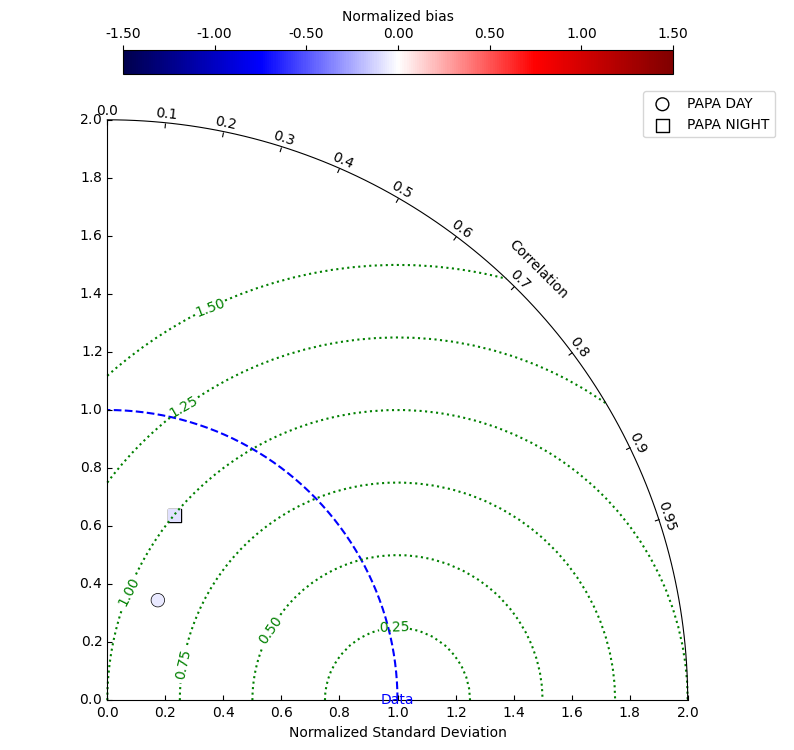

In [26]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_papa_plot_day,
    biomass_papa_plot_night,
]
all_obs = [
    obs_papa_plot_day,
    obs_papa_plot_night,
]

all_names = ["PAPA DAY", "PAPA NIGHT"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)

diagram.plot()